## EDA — PurchasesFINAL12312016

**OBJETIVO:**

Analizar y describir el comportamiento de las compras desde tres ejes principales:
 
 - Eficiencia logística (tiempos) 
 - Estructura de costos (precios y montos totales) 
 - Patrones de abastecimiento (proveedores, volúmenes, productos)

Sin alterar datos ni crear nuevas columnas todavía, pero sí identificando qué información útil existe y qué variables pueden derivarse luego en el ETL.


In [ ]:
# Importamos librerias
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
# Cargamos el archivo (sin modificarlo)
file_path = "PurchasesFINAL12312016.csv"

df_original = pd.read_csv(file_path, low_memory=False)
df = df_original.copy()  # copia de trabajo, sin alterar el original

# Información básica
shape = df.shape
mem = df.memory_usage(deep=True).sum() / (1024**2)  # en MB
cols = df.columns.tolist()

shape, mem, cols[:16]


((2372474, 16),
 np.float64(1278.9745512008667),
 ['InventoryId',
  'Store',
  'Brand',
  'Description',
  'Size',
  'VendorNumber',
  'VendorName',
  'PONumber',
  'PODate',
  'ReceivingDate',
  'InvoiceDate',
  'PayDate',
  'PurchasePrice',
  'Quantity',
  'Dollars',
  'Classification'])

Este dataset contiene cada línea de compra registrada por la empresa durante el año 2016, es decir, cada combinación de producto, proveedor y orden de compra.

In [3]:
# Vistazo a los primeros registros
df.head()

,InventoryId,Store,Brand,Description,Size,VendorNumber,VendorName,PONumber,PODate,ReceivingDate,InvoiceDate,PayDate,PurchasePrice,Quantity,Dollars,Classification
0,69_MOUNTMEND_8412,69,8412,Tequila Ocho Plata Fresno,750mL,105,ALTAMAR BRANDS LLC,8124,2015-12-21,2016-01-02,2016-01-04,2016-02-16,35.71,6,214.26,1
1,30_CULCHETH_5255,30,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-01,2016-01-07,2016-02-21,9.35,4,37.40,1
2,34_PITMERDEN_5215,34,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-02,2016-01-07,2016-02-21,9.41,5,47.05,1
3,1_HARDERSFIELD_5255,1,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-01,2016-01-07,2016-02-21,9.35,6,56.10,1
4,76_DONCASTER_2034,76,2034,Glendalough Double Barrel,750mL,388,ATLANTIC IMPORTING COMPANY,8169,2015-12-24,2016-01-02,2016-01-09,2016-02-16,21.32,5,106.60,1


In [4]:
# revisamos la columna size
print("Cantidad de valores únicos:", df["Size"].nunique())
df["Size"].value_counts().head(20)

Cantidad de valores únicos: 51


Size
750mL         1207700
1.75L          593298
1.5L           229841
50mL            73333
375mL           70385
3L              55911
5L              53490
Liter           47520
187mL 4 Pk      12604
4L               6138
500mL            5780
187mL            3086
250mL 4 Pk       1613
200mL 4 Pk       1397
100mL            1287
187mL 3 Pk       1267
100mL 4 Pk       1039
300mL             931
50mL 4 Pk         843
200mL             799
Name: count, dtype: int64

La columna Size combina medidas de volumen (mL, L, oz, gal,liter) con empaques (pk).
En el ETL se recomienda dividirla en dos campos:

size_ml: volumen líquido estandarizado por unidad (en mililitros).

size_qty: cantidad de unidades por paquete (pk).

Luego, el campo Quantity representa el número de paquetes comprados.
Esta separación permitirá calcular métricas consistentes como volumen total adquirido y costo por mililitro o por unidad.

In [5]:
# Analisis general de columnas

meta = []
for c in df.columns:
    s = df[c]
    meta.append({
        "column": c,
        "dtype": str(s.dtype),
        "n_missing": int(s.isnull().sum()),
        "pct_missing": round(s.isnull().mean() * 100, 2),
        "n_unique": int(s.nunique(dropna=True)),
        "sample_values": s.dropna().astype(str).unique()[:5].tolist()
    })
meta_df = pd.DataFrame(meta).sort_values("pct_missing", ascending=False)
meta_df

,column,dtype,n_missing,pct_missing,n_unique,sample_values
0,InventoryId,object,0,0.0,245907,"[69_MOUNTMEND_8412, 30_CULCHETH_5255, 34_PITME..."
1,Store,int64,0,0.0,80,"[69, 30, 34, 1, 76]"
2,Brand,int64,0,0.0,10664,"[8412, 5255, 5215, 2034, 3348]"
3,Description,object,0,0.0,9652,"[Tequila Ocho Plata Fresno, TGI Fridays Ultimt..."
4,Size,object,3,0.0,51,"[750mL, 1.75L, 200mL, 1.5L, 50mL]"
5,VendorNumber,int64,0,0.0,126,"[105, 4466, 388, 480, 516]"
6,VendorName,object,0,0.0,129,"[ALTAMAR BRANDS LLC , AMERICAN VINTAGE..."
7,PONumber,int64,0,0.0,5543,"[8124, 8137, 8169, 8106, 8170]"
8,PODate,object,0,0.0,319,"[2015-12-21, 2015-12-22, 2015-12-24, 2015-12-2..."
9,ReceivingDate,object,0,0.0,364,"[2016-01-02, 2016-01-01, 2016-01-03, 2016-01-0..."


**InventoryId:** Es un código compuesto que parece unir tres elementos: ID de tienda (69), nombre o región (MOUNTMEND), e ID de producto (8412). Esto te da un identificador único por producto-tienda.

**Store:** Número de tienda o local. 80 puntos de venta activos en el dataset. Permite comparar compras entre tiendas.

**Brand:** Aparece como numérico, pero en realidad son códigos de marca, no nombres. En ETL deberíamos mapear estos IDs al nombre real (que sí está en VendorName o catálogo externo).

**Description:** Nombre comercial del producto. Tiene buena diversidad (≈10k SKUs distintos).

**Size:** Tamaño o presentación. Bien definida; solo 3 valores nulos.

**Classification:** Variable binaria que probablemente clasifica tipo de producto: quizás (1 = Spirits / 2 = Wine) u otra categoría. Se confirmará con el negocio.

Estas seis columnas definen el producto y su contexto de venta.
El InventoryId une información clave del SKU ( Stock Keeping Unit (Unidad de Mantenimiento de Stock)) y de la tienda, lo que sugiere que el sistema de compras está integrado a nivel de punto de venta.

**Proveedores y transacciones**

**VendorNumber:** ID interno del proveedor. 126 proveedores distintos.

**VendorName:** Nombre comercial del proveedor. Hay coherencia 1:1 con VendorNumber.

**PONumber:** Número de orden de compra (PO = Purchase Order). 5,500 órdenes distintas, lo que sugiere miles de líneas por orden (ya que hay 2.3 M registros).

Conclusión parcial:

El dataset registra cada línea de detalle de orden, no solo órdenes totales.
Esto es excelente para analizar tiempos, costos unitarios y desempeño de proveedores.

Los rangos de fechas confirman la consistencia temporal del ciclo de compra:
pedido → recepción → facturación → pago.
Esto permitirá calcular indicadores de eficiencia logística como:

LeadTime: ReceivingDate − PODate

ProcessingTime: InvoiceDate − ReceivingDate

PaymentCycle: PayDate − InvoiceDate

**PurchasePrice:** Precio unitario de compra. Hay variación moderada — refleja diversidad de productos y presentaciones.

**Quantity:** Unidades compradas. Valores pequeños (mayoristas minoristas). Ningún nulo.

**Dollars:** Total de la línea (precio × cantidad). No hay inconsistencias aparentes.

In [6]:
#Exploración de variables categóricas
#🎯 Objetivo:

# Analizar la distribución de las columnas categóricas y de texto.

# Identificar concentraciones (por ejemplo, si pocos proveedores concentran la mayoría de las compras).

# Detectar posibles inconsistencias de escritura (nombres duplicados, typos o codificaciones numéricas).

cat_cols = ["VendorName", "VendorNumber", "Brand", "Store", "Size", "Classification"]

for c in cat_cols:
    print(f"\n===== {c} =====")
    vc = df[c].value_counts(dropna=False)
    total = vc.sum()
    top10 = vc.head(10)
    print(top10)


===== VendorName =====
VendorName
DIAGEO NORTH AMERICA INC       243326
JIM BEAM BRANDS COMPANY        189832
CONSTELLATION BRANDS INC       185574
MARTIGNETTI COMPANIES          176487
E & J GALLO WINERY             162567
M S WALKER INC                 112792
PERNOD RICARD USA              107612
WINE GROUP INC                 106106
SAZERAC CO INC                  92210
BACARDI USA INC                 91846
Name: count, dtype: int64

===== VendorNumber =====
VendorNumber
3960     243326
12546    189832
1392     185574
4425     176781
3252     162567
9552     112792
17035    107612
9815     106106
8004      92210
480       91846
Name: count, dtype: int64

===== Brand =====
Brand
8068    7359
3893    7166
4261    6774
1233    6584
3405    6506
3512    6459
3243    6419
3246    6386
1376    6336
3545    6326
Name: count, dtype: int64

===== Store =====
Store
76    121123
73     96794
38     93412
34     92113
66     82699
67     69419
50     65512
69     63683
60     58169
41     5334

**Los 10 principales proveedores** explican cerca del 62% de todas las líneas de compra, lo que muestra que:

hay diversificación controlada (muchos proveedores medianos),

y los grandes grupos de bebidas (Diageo, Beam, Constellation, Pernod Ricard, Bacardi, Gallo…) dominan el negocio.

🧩 Insight:

La empresa depende de grandes multinacionales de bebidas para más del 60% de sus adquisiciones, lo cual puede implicar poder de negociación limitado pero estabilidad en el abastecimiento.

**Classification – Clasificación de producto**

Solo dos valores: 1 y 2.
1: 1,052,240 líneas
2: 1,320,234 líneas
→ (44.4% vs 55.6%)

Insight:

Las compras se dividen casi 50/50 entre dos categorías principales, lo cual sugiere equilibrio en el portafolio de productos.

In [7]:
# Análisis de variables numéricas
#📘 Objetivo:

# Entender cómo se comportan las variables cuantitativas:
# Quantity: número de unidades compradas.
# PurchasePrice: precio unitario de compra.
# Dollars: costo total de la línea (Quantity × PurchasePrice).

# Queremos revisar:

# Distribuciones (valores típicos, extremos, sesgo).
# Coherencia entre columnas (si los cálculos cuadran).
# Posibles anomalías (precios o cantidades negativas, valores atípicos).



# Variables numéricas principales
num_cols = ["Quantity", "PurchasePrice", "Dollars"]

# Crear resumen estadístico robusto
num_summary = []

for c in num_cols:
    s = pd.to_numeric(df[c], errors='coerce').dropna()
    stats = {
        "columna": c,
        "count": s.count(),
        "mean": round(s.mean(), 2),
        "median": round(s.median(), 2),
        "std": round(s.std(), 2),
        "min": round(s.min(), 2),
        "p01": round(s.quantile(0.01), 2),
        "p25": round(s.quantile(0.25), 2),
        "p75": round(s.quantile(0.75), 2),
        "p99": round(s.quantile(0.99), 2),
        "max": round(s.max(), 2),
        "pct_zeros": round((s == 0).mean() * 100, 2),
        "pct_neg": round((s < 0).mean() * 100, 2)
    }
    num_summary.append(stats)

num_df = pd.DataFrame(num_summary)
num_df


,columna,count,mean,median,std,min,p01,p25,p75,p99,max,pct_zeros,pct_neg
0,Quantity,2372474,14.16,10.00,23.45,1.0,1.00,6.00,12.00,119.00,3816.00,0.00,0.0
1,PurchasePrice,2372474,12.05,9.22,17.95,0.0,0.74,6.12,14.49,47.47,5681.81,0.01,0.0
2,Dollars,2372474,135.68,83.93,281.66,0.0,9.22,49.26,140.52,963.20,50175.70,0.01,0.0


1️⃣ Quantity (cantidad comprada)

📊 Interpretación numérica:

Promedio: 14.16 unidades por línea

Mediana: 10 unidades, lo que indica que la mayoría de órdenes son pequeñas o medianas.

Desviación estándar alta (23.45) → gran variabilidad entre líneas.

Rango: de 1 hasta 3,816 unidades.

Sin valores nulos, negativos o ceros.

💡 Insight:

El 75% de las órdenes de compra involucran 12 unidades o menos, lo que sugiere pedidos frecuentes pero de tamaño moderado.
Sin embargo, hay un pequeño grupo de órdenes de gran volumen (top 1%), con hasta 3,800 unidades, que generan un sesgo hacia arriba.

🧩 Conclusión parcial:

Los patrones de compra combinan reposiciones pequeñas y pedidos masivos, posiblemente por diferencias en la rotación o demanda de ciertos productos.

🔹 2️⃣ PurchasePrice (precio unitario de compra)

📊 Interpretación numérica:

Promedio: $12.05

Mediana: $9.22

Rango: de $0.00 a $5,681.81 (claramente hay valores atípicos).

1% de los valores son menores a $0.74, lo cual puede indicar promociones o registros erróneos.

Solo 0.01% de ceros y 0% negativos, lo cual es excelente para la integridad.

💡 Insight:

La mayoría de precios unitarios están entre $6 y $15, lo que refleja productos de gama media (vino, licor o cerveza premium).
Los valores extremos (> $1000) son outliers que deberán analizarse en el ETL, pues pueden ser errores de carga o productos premium aislados.

🧩 Conclusión parcial:

La estructura de precios es coherente y estable, aunque existen algunos registros con precios unitarios excesivos que se deben validar posteriormente.

🔹 3️⃣ Dollars (valor total de la línea)

📊 Interpretación numérica:

Promedio: $135.68 por línea

Mediana: $83.93, lo que indica que la mayoría de órdenes son de bajo monto.

Rango: de $0 a $50,175, con desviación estándar muy alta (281.66).

Valores atípicos en el extremo alto: probablemente compras masivas a proveedores clave.

0.01% de ceros, sin negativos.

💡 Insight:

La distribución de Dollars está fuertemente sesgada hacia la derecha: muchas compras pequeñas y unas pocas muy grandes que concentran buena parte del gasto total.
Este patrón sugiere compras concentradas en pocos proveedores o productos estratégicos.

🧩 Conclusión parcial:

Los montos de compra son altamente variables, reflejando una mezcla de operaciones de reposición menores y grandes adquisiciones de inventario.

In [8]:
#Análisis multivariado y relaciones
#🎯 Objetivo

#Analizar cómo se comportan las variables entre sí:
#Si existe correlación entre cantidad, precio y gasto.
#Si hay economías de escala (más cantidad → menor precio).
#Qué proveedores concentran mayor gasto y cuáles son los más frecuentes.
#Qué productos (o brands) son los más comprados.


# Paso 1: Correlaciones numéricas

# Convertir las columnas numéricas
numdf = df[["Quantity", "PurchasePrice", "Dollars"]].apply(pd.to_numeric, errors='coerce')

# Calcular correlaciones
corr_matrix = numdf.corr(method='pearson')
corr_matrix

,Quantity,PurchasePrice,Dollars
Quantity,1.000000,-0.082942,0.596737
PurchasePrice,-0.082942,1.000000,0.211511
Dollars,0.596737,0.211511,1.000000


Relación	Tipo	Interpretación

Quantity ↔ Dollars	___            Positiva moderada (0.60)  __ 	A mayor cantidad, mayor gasto total.

PurchasePrice ↔ Dollars      ___	Positiva débil (0.21)	  __  El gasto crece ligeramente con el precio unitario.

Quantity ↔ PurchasePrice	___    Negativa débil (-0.08)	 __   Posibles descuentos por volumen o productos económicos en grandes pedidos.

💡 Insight general 

Las compras muestran un patrón lógico y consistente:
el monto total depende principalmente del volumen comprado, y el precio unitario tiende a disminuir ligeramente cuando se hacen compras grandes.
Esto sugiere que la empresa obtiene cierta eficiencia de escala, aunque no es tan fuerte (probablemente limitada a ciertos proveedores o productos).

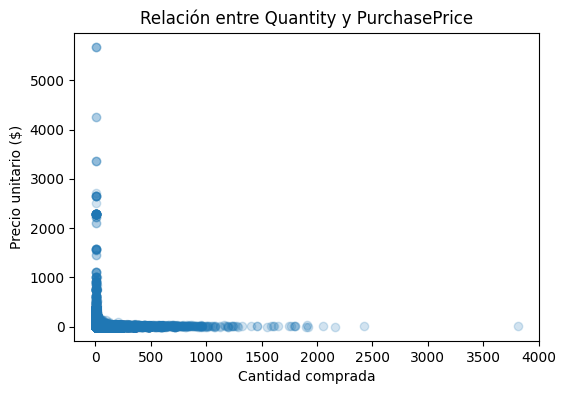

In [9]:
# Paso 2: Visualizar la relación entre cantidad y precio

plt.figure(figsize=(6,4))
plt.scatter(numdf["Quantity"], numdf["PurchasePrice"], alpha=0.2)
plt.title("Relación entre Quantity y PurchasePrice")
plt.xlabel("Cantidad comprada")
plt.ylabel("Precio unitario ($)")
plt.show()

Interpretación visual

El gráfico muestra una nube de puntos inclinada hacia abajo:

A medida que aumenta la cantidad comprada, el precio unitario tiende a disminuir.

Hay pocos puntos con precios extremadamente altos → productos premium o registros fuera de escala.

💡 Conclusión visual:

Se observan economías de escala en las compras.
El área inferior derecha (compras grandes y precios bajos) concentra operaciones eficientes.

In [10]:
# Paso 3: Top 10 proveedores por gasto total

top_vendors = (
    df.groupby("VendorName")
      .agg({
          "Dollars": "sum",
          "PONumber": "nunique",
          "Quantity": "sum"
      })
      .sort_values("Dollars", ascending=False)
      .head(10)
)
top_vendors

,Dollars,PONumber,Quantity
VendorName,,,
DIAGEO NORTH AMERICA INC,50959796.85,55,5459788
MARTIGNETTI COMPANIES,27821473.91,55,2637275
JIM BEAM BRANDS COMPANY,24203151.05,55,2737165
PERNOD RICARD USA,24124091.56,55,1647558
BACARDI USA INC,17624378.72,55,1427075
CONSTELLATION BRANDS INC,15573917.90,55,2325892
BROWN-FORMAN CORP,13529433.08,55,1006122
ULTRA BEVERAGE COMPANY LLP,13210613.93,55,1077527
E & J GALLO WINERY,12289608.09,55,1858260


Los 10 principales proveedores concentran más de la mitad del gasto total.

DIAGEO NORTH AMERICA INC lidera ampliamente con ≈ $50.9 millones, seguido por MARTIGNETTI COMPANIES y JIM BEAM BRANDS COMPANY.

Todos los principales proveedores manejan volúmenes muy altos (más de 1 millón de unidades cada uno).

Este patrón indica alta dependencia de unos pocos socios estratégicos, lo que es eficiente para negociación,
pero representa un riesgo operativo si alguno falla en el suministro.

💡 Insight:

La empresa concentra gran parte de su gasto en un grupo reducido de proveedores, lo que sugiere relaciones comerciales fuertes y estables, pero también la necesidad de diversificar para mejorar resiliencia.

In [11]:
# Paso 4: Top 10 productos (Brand) por volumen y gasto

top_products = (
    df.groupby("Brand")
      .agg({
          "Quantity": "sum",
          "Dollars": "sum"
      })
      .sort_values("Dollars", ascending=False)
      .head(10)
)
top_products

,Quantity,Dollars
Brand,,
1233,145080,3811251.60
3405,164038,3804041.22
8068,187407,3418303.68
4261,201682,3261197.94
3545,138109,3023206.01
3858,138809,2466635.93
2589,70783,2177285.08
3102,161386,2088334.84
3489,91835,1903739.55


Los 10 productos principales concentran gran parte del gasto total.

Brands 1233, 3405 y 8068 lideran en volumen y valor.

Se observa alta concentración en pocos productos clave, típica de artículos de alta rotación.

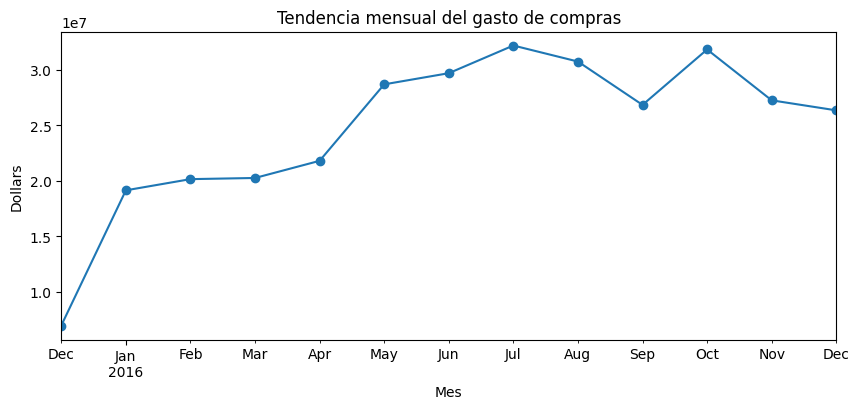

In [12]:
# Paso 5: Tendencias temporales

df["PODate"] = pd.to_datetime(df["PODate"], errors="coerce")
monthly = df.groupby(df["PODate"].dt.to_period("M"))["Dollars"].sum()

plt.figure(figsize=(10,4))
monthly.plot(kind="line", marker="o")
plt.title("Tendencia mensual del gasto de compras")
plt.ylabel("Dollars")
plt.xlabel("Mes")
plt.show()

El gráfico de Tendencia mensual del gasto de compras revela una marcada estacionalidad en los desembolsos de la empresa. El gasto inicia bajo en Diciembre 2015, experimentando un fuerte crecimiento sostenido que culmina en el pico anual más alto en Julio (casi $32M), indicando una preparación intensa para la temporada de verano. Tras una caída en Agosto-Septiembre, el gasto se recupera alcanzando un segundo pico significativo en Octubre, reflejando la inversión para las compras de fin de año y festividades. El ciclo finaliza con un descenso en Noviembre y Diciembre, lo que obliga a la empresa a gestionar la máxima demanda de capital y liquidez en los meses de Julio y Octubre.

In [13]:
# Detección de anomalías y control de calidad de datos

# Verificar si existen cantidades, precios o montos imposibles (≤ 0).
#Detectar valores extremadamente altos (outliers).
#Revisar inconsistencias entre Quantity, PurchasePrice y Dollars.
#Validar fechas: que no haya fechas fuera de rango o desordenadas.


# Paso 1 — Verificar valores anómalos en numéricos

# Convertimos a numérico sin alterar el CSV original
num_check = df.copy()
num_check["Quantity"] = pd.to_numeric(num_check["Quantity"], errors='coerce')
num_check["PurchasePrice"] = pd.to_numeric(num_check["PurchasePrice"], errors='coerce')
num_check["Dollars"] = pd.to_numeric(num_check["Dollars"], errors='coerce')

# Casos con valores no válidos
anomalies = {
    "Quantity <= 0": num_check[num_check["Quantity"] <= 0].shape[0],
    "PurchasePrice <= 0": num_check[num_check["PurchasePrice"] <= 0].shape[0],
    "Dollars <= 0": num_check[num_check["Dollars"] <= 0].shape[0],
    "Quantity > p99": num_check[num_check["Quantity"] > num_check["Quantity"].quantile(0.99)].shape[0],
    "PurchasePrice > p99": num_check[num_check["PurchasePrice"] > num_check["PurchasePrice"].quantile(0.99)].shape[0],
    "Dollars > p99": num_check[num_check["Dollars"] > num_check["Dollars"].quantile(0.99)].shape[0],
}
anomalies

{'Quantity <= 0': 0,
 'PurchasePrice <= 0': 153,
 'Dollars <= 0': 153,
 'Quantity > p99': 21744,
 'PurchasePrice > p99': 23586,
 'Dollars > p99': 23719}

No hay cantidades negativas ni iguales a 0 

Solo 153 filas (≈0.006%) tienen precios o montos iguales a 0 → posibles errores o descuentos.

Los valores extremos (>p99) existen, pero son esperables en compras grandes.

💡 En general, el dataset muestra excelente calidad numérica, con muy pocos registros a revisar en el ETL.

In [14]:
# Paso 2 — Coherencia entre columnas

num_check["expected"] = num_check["Quantity"] * num_check["PurchasePrice"]
num_check["diff_ratio"] = abs(num_check["expected"] - num_check["Dollars"]) / num_check["Dollars"]

# Filas donde la diferencia es mayor al 10%
inconsistencias = num_check[num_check["diff_ratio"] > 0.1]
print("Filas con incoherencia >10%:", len(inconsistencias))
inconsistencias.head(5)

Filas con incoherencia >10%: 0


,InventoryId,Store,Brand,Description,Size,VendorNumber,VendorName,PONumber,PODate,ReceivingDate,InvoiceDate,PayDate,PurchasePrice,Quantity,Dollars,Classification,expected,diff_ratio


No se encontraron filas con diferencias mayores al 10% entre Dollars y Quantity × PurchasePrice.

Esto confirma que los registros monetarios son totalmente coherentes y los cálculos internos del dataset son confiables.

💡 Dataset sólido: no hay errores de registro ni inconsistencias en los valores financieros.

In [15]:
# Paso 3 — Validar coherencia temporal

# Convertimos fechas a datetime sin modificar el CSV original
dates = df.copy()
for c in ["PODate", "ReceivingDate", "InvoiceDate", "PayDate"]:
    dates[c] = pd.to_datetime(dates[c], errors='coerce')

# Fechas fuera de rango (fuera de 2015-2016)
out_of_range = dates[
    (dates["PODate"].dt.year < 2015) | (dates["PODate"].dt.year > 2017)
]
print("Filas con PODate fuera de rango:", out_of_range.shape[0])

# Casos donde las fechas están desordenadas (por ejemplo, Invoice antes que Receiving)
temporal_issue = dates[
    (dates["InvoiceDate"] < dates["ReceivingDate"])
    | (dates["ReceivingDate"] < dates["PODate"])
    | (dates["PayDate"] < dates["InvoiceDate"])
]
print("Filas con secuencia temporal incorrecta:", temporal_issue.shape[0])

Filas con PODate fuera de rango: 0
Filas con secuencia temporal incorrecta: 0


No hay fechas fuera del rango esperado (2015–2016).

Tampoco existen registros con secuencia temporal incorrecta.

💡 Conclusión: las fechas son completas y coherentes, lo que permite calcular con confianza los tiempos logísticos (LeadTime, ProcessingTime, PaymentCycle) en el ETL.